# **Ian Yung (icy4r)**
### *04.10.2024*
### *early-project.ipynb*

In [1]:
import pandas as pd
import numpy as np
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import plotly_express as px
import seaborn as sns
from IPython.display import display, HTML

import re

import nltk
from nltk import pos_tag

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import gensim
from scipy.linalg import norm, eigh
from gensim.corpora import Dictionary
from gensim.models import LdaModel, word2vec
from sklearn.manifold import TSNE as tsne

In [2]:
path = "The Complete Works of J.R.R Tolkien/Tolkien/The Fellowship of the Ring/The Fellowship of the Ring_ The - J. R. R. Tolkien.epub"

### Converting EBooks into Text using BeautifulSoup

In [3]:
blacklist = [   '[document]',   'noscript', 'header',   'html', 'meta', 'head','input', 'script',   ]
# there may be more elements you don't want, such as "style", etc.

In [4]:
def epub2thtml(epub_path):
    book = epub.read_epub(epub_path)
    chapters = []
    for item in book.get_items():
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            chapters.append(item.get_content())
    return chapters

In [5]:
def chap2text(chap):
    output = ''
    soup = BeautifulSoup(chap, 'html.parser')
    text = soup.find_all(text=True)
    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
    return output

In [6]:
def thtml2ttext(thtml):
    Output = []
    for html in thtml:
        text =  chap2text(html)
        Output.append(text)
    return Output

In [7]:
def epub2text(epub_path):
    chapters = epub2thtml(epub_path)
    ttext = thtml2ttext(chapters)
    return ttext

In [8]:
paths = [
    "The Complete Works of J.R.R Tolkien/Tolkien/The Fellowship of the Ring/The Fellowship of the Ring_ The - J. R. R. Tolkien.epub",
    'The Complete Works of J.R.R Tolkien/Tolkien/The Two Towers/The Two Towers_ The Lord of the - J. R. R. Tolkien.epub',
    "The Complete Works of J.R.R Tolkien/Tolkien/The Return of the King/The Return of the King_ The Lor - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/Bilbo's Last Song/Bilbo's Last Song - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/Tales From the Perilous Realm/Tales From the Perilous Realm - J. R. R. Tolkien.epub",
    'The Complete Works of J.R.R Tolkien/Tolkien/The Book of Lost Tales, Part 1/The Book of Lost Tales, Part 1 - J. R. R. Tolkien.epub',
    "The Complete Works of J.R.R Tolkien/Tolkien/The Book of Lost Tales, Part 2/The Book of Lost Tales, Part 2 - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Children of Hurin/The Children of Hurin - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Hobbit/The Hobbit - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Legend of Sigurd and Gudrun/The Legend of Sigurd and Gudrun - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Letters of J.R.R. Tolkien/The Letters of J.R.R. Tolkien - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Return of the Shadow/The Return of the Shadow_ The H - J. R. R. Tolkien.epub",
    "The Complete Works of J.R.R Tolkien/Tolkien/The Silmarillion/The Silmarillion - J. R. R. Tolkien.epub",
]

text_beginnings = [9, 9, 10, 6, 4, 5, 4, 4, 12, 11, 4, 2, 11] # either the preface, prologue, or the first chapter
text_endings = [33, 31, 29, 6, 33, 14, 9, 23, 30, 19, 358, 29, 58]

In [9]:
texts = []
for p in paths:
    text = epub2text(p)
    texts.append(text)

/Users/ianyung/miniconda3/lib/python3.11/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
/Users/ianyung/miniconda3/lib/python3.11/site-packages/ebooklib/epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):
/var/folders/c_/pj7tcp6d3w15s5d8gn2j4qth0000gn/T/ipykernel_27944/3781084737.py:4: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  text = soup.find_all(text=True)


In [10]:
# keep track of which text you're parsing through
text_index = 2
text_start = text_beginnings[text_index]
text_end = text_endings[text_index]

# check the text
# texts[text_index][text_start:text_end+1]

In [11]:
# clip the texts
clipped_texts = []
for text_index in range(len(texts)):
    text_start = text_beginnings[text_index]
    text_end = text_endings[text_index]

    clipped_text = texts[text_index][text_start:text_end+1]
    clipped_texts.append(clipped_text)

### Making an OHCO

In [12]:
# contains all the regexes to splice the chapters of all the books
regs = [r"\n\s*Chapter\s*(\d+)\s*(.*?)\s*(.*?)\s*\n",
       'Chapter\s+\d+\s*\n.+\n',
       r"\n\s*Chapter\s*(\d+)\s*(.*?)\s*(.*?)\s*\n",
       '\n\s*\n\s*Chapter\s+[IVXLCDM]+\s*\n.*\n',
       "(?:\n\s*){3}([IVXLCDM]+)\s*(.*?)\s*(?:\n\s*){3}",
       "(?:\n\s*){3}([IVXLCDM]+)\s*(.*?)\s*(?:\n\s*){3}",
       '.*? \n ',]

In [13]:
'''
Helper function used to splice the chapters so only the content is left.
'''
def splice_string(string, regex_pattern):
    match = re.search(regex_pattern, string)
    if match:
        return string[match.end():]
    else:
        return string

def make_ohco(df, reg, para_split=r'\r\n\s+\n'):
    # setup
    OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']

    # actually create the OHCO
    CHAPS = df.map(lambda x: splice_string(x, reg))
    
    PARAS = CHAPS['chapter'].str.split(para_split, expand=True).stack().to_frame('para_str')
    PARAS['para_str'] = PARAS['para_str'].str.replace(r'\r\n|\n', ' ', regex=True).str.strip() # remove the \r\n's.
    PARAS.index.names = OHCO[:2]

    SENTS = PARAS['para_str'].str.split(r'[.?!;:"]+', expand=True).stack()\
        .to_frame().rename(columns={0:'sent_str'})
    SENTS.index.names = OHCO[:3]
    SENTS = SENTS[~SENTS['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs
    SENTS.sent_str = SENTS.sent_str.str.strip()

    TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
    TOKENS.index.names = OHCO[:4]
    TOKENS['term_str'] = TOKENS.token_str.str.replace(r"[\W_]+", '', regex=True).str.lower()

    return TOKENS

In [14]:
fellowship_TEXT= pd.DataFrame({'chapter': clipped_texts[0][2:]}, index=range(0, len(clipped_texts[1])))
fellowship_TEXT.drop([12], inplace=True)

towers_TEXT = pd.DataFrame({'chapter': clipped_texts[1]}, index=range(1, len(clipped_texts[0]) - 1))
towers_TEXT.drop([13], inplace=True)

king_TEXT = pd.DataFrame({'chapter': clipped_texts[2]}, index=range(len(clipped_texts[2])))
king_TEXT.drop([10], inplace=True)

hobbit_TEXT = pd.DataFrame({'chapter': clipped_texts[8]}, index=range(0, len(clipped_texts[8])))

tales_one_TEXT = pd.DataFrame({'chapter': clipped_texts[5]}, index=range(0, len(clipped_texts[5])))
tales_two_TEXT = pd.DataFrame({'chapter': clipped_texts[6]}, index=range(0, len(clipped_texts[6])))

# silmarillion requires a little more work
silmarillion_TEXT = pd.DataFrame({'chapter': clipped_texts[12]}, index=range(0, len(clipped_texts[12])))
mask = silmarillion_TEXT.index % 2 == 0
odd_indices = ~mask
silmarillion_TEXT = silmarillion_TEXT[odd_indices]

In [15]:
fellow = make_ohco(fellowship_TEXT, regs[0])
towers = make_ohco(towers_TEXT, regs[1])
king = make_ohco(king_TEXT, regs[2])
hobbit = make_ohco(hobbit_TEXT, regs[3])
talesONE = make_ohco(tales_one_TEXT, regs[4], para_split=r'\n')
talesTWO = make_ohco(tales_two_TEXT, regs[5], para_split=r'\n')
silmarillion = make_ohco(silmarillion_TEXT, regs[6], para_split=r'\n')

## Create LIB

In [16]:
fellow['book_id'] = 1
towers['book_id'] = 2
king['book_id'] = 3
hobbit['book_id'] = 4
talesONE['book_id'] = 5
talesTWO['book_id'] = 6
silmarillion['book_id'] = 7

In [17]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

fellow = fellow.reset_index().set_index(OHCO)
towers = towers.reset_index().set_index(OHCO)
king = king.reset_index().set_index(OHCO)
hobbit = hobbit.reset_index().set_index(OHCO)
talesONE = talesONE.reset_index().set_index(OHCO)
talesTWO = talesTWO.reset_index().set_index(OHCO)
silmarillion = silmarillion.reset_index().set_index(OHCO)

In [18]:
# %% TODO - add the "n_chaps" column to LIB %%
LIB = pd.DataFrame(columns=['book_title', 'book_author', 'date'], index=[1, 2, 3, 4])
LIB.loc[1, ['book_title', 'book_author', 'date', 'book_len']] = ("Fellowship of the Ring", "J.R.R. Tolkien", "1954", int(len(fellow)))
LIB.loc[2, ['book_title', 'book_author', 'date', 'book_len']] = ("The Two Towers", "J.R.R. Tolkien", "1954", int(len(towers)))
LIB.loc[3, ['book_title', 'book_author', 'date', 'book_len']] = ("Return of the King", "J.R.R. Tolkien", "1955", int(len(king)))
LIB.loc[4, ['book_title', 'book_author', 'date', 'book_len']] = ("The Hobbit", "J.R.R. Tolkien", "1937", int(len(hobbit)))
LIB.loc[5, ['book_title', 'book_author', 'date', 'book_len']] = ("The Book of Lost Tales, Part 1", "J.R.R. Tolkien", "1983", int(len(talesONE)))
LIB.loc[6, ['book_title', 'book_author', 'date', 'book_len']] = ("The Book of Lost Tales, Part 2", "J.R.R. Tolkien", "1984", int(len(talesTWO)))
LIB.loc[7, ['book_title', 'book_author', 'date', 'book_len']] = ("The Silmarillion", "J.R.R. Tolkien", "1977", int(len(silmarillion)))

LIB.index.name = "book_id"

In [19]:
LIB

book_title     book_author  date  book_len
book_id                                                                
1                Fellowship of the Ring  J.R.R. Tolkien  1954  182850.0
2                        The Two Towers  J.R.R. Tolkien  1954  160213.0
3                    Return of the King  J.R.R. Tolkien  1955  138585.0
4                            The Hobbit  J.R.R. Tolkien  1937   97251.0
5        The Book of Lost Tales, Part 1  J.R.R. Tolkien  1983  108638.0
6        The Book of Lost Tales, Part 2  J.R.R. Tolkien  1984  158964.0
7                      The Silmarillion  J.R.R. Tolkien  1977  102262.0

## Create CORPUS

In [20]:
CORPUS = pd.concat([fellow, towers, king, hobbit, talesONE, talesTWO, silmarillion])

In [21]:
# create POS tags
pos_tags = pos_tag(CORPUS.token_str)

CORPUS['pos_tuple'] = pos_tags
CORPUS['pos'] = [j for i, j in pos_tags]
CORPUS['pos_group'] = CORPUS.pos.str[:2]

## Create VOCAB

In [22]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

In [23]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

## Add Stopwords

In [24]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [25]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

## Generate BOW and Calculate DFIDF

In [26]:
'''
Borrowed from M05_HW_KEY.ipynb!

Generates a BOW given a CORPUS and a bag.
'''
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

'''
Borrowed from M06_HW_KEY.ipynb!

Generates both TFIDF and DFIDF values from BOW.
'''
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

In [27]:
CHAP = OHCO[:2]
BOW = create_bow(CORPUS, CHAP)
TFIDF, df = get_tfidf(BOW)

In [28]:
BOW['tfidf'] = TFIDF.stack()
VOCAB['dfidf'] = df

In [29]:
# 20 most-significant words according to DFIDF value
VOCAB.sort_values('dfidf', ascending=False).head(20)
VOCAB_final = VOCAB

## DTM

In [30]:
TFIDF.fillna(0).groupby('chap_num').mean().stack() # MUST FILLNA

chap_num  term_str
0                     0.018981
          1           0.002167
          10          0.004231
          100         0.003246
          10022       0.000000
                        ...   
47        þa          0.000000
          þisses      0.000000
          þunor       0.000000
          þá          0.000000
          þórr        0.000000
Length: 733140, dtype: float64

In [31]:
'''
Borrowed from M00_01_VectorizationWithSKLearn.ipynb

Simply condenses the CORPUS to the desired OHCO level.
'''
def gather_docs(CORPUS, ohco_level, term_col='term_str'):
    OHCO = CORPUS.index.names
    CORPUS[term_col] = CORPUS[term_col].astype('str')
    DOC = CORPUS.groupby(OHCO[:ohco_level])[term_col].apply(lambda x:' '.join(x)).to_frame('doc_str')
    return DOC

DOC = gather_docs(CORPUS, 3) # change the second parameter for different BAG

# Calculates the number of tokens in each cell
DOC['n_tokens'] = DOC.doc_str.apply(lambda x: len(x.split()))

In [32]:
# mutable variables
ngram_range = (1,2)
n_terms = 4000

count_engine = CountVectorizer(
    stop_words = 'english',
    ngram_range = ngram_range,
    max_features = n_terms)

X = count_engine.fit_transform(DOC.doc_str)

# Create the DTM from the transformed OHCO
DTM = pd.DataFrame(X.toarray(), 
                   columns=count_engine.get_feature_names_out(), 
                   index=DOC.index)

In [33]:
DTM.head()

10  11  12  13  14  15  16  17  18  19  ...  youth  \
book_id chap_num para_num                                          ...          
1       0        0          0   0   0   0   0   0   0   0   0   0  ...      0   
                 1          0   0   0   0   0   0   0   0   0   0  ...      1   
                 2          0   0   0   0   0   0   0   0   0   0  ...      0   
                 3          0   0   0   0   0   0   0   0   0   0  ...      0   
                 4          0   0   0   0   0   0   0   0   0   0  ...      0   

                           youve  ythlings  ælfwine  ælfwine england  \
book_id chap_num para_num                                              
1       0        0             0         0        0                0   
                 1             0         0        0                0   
                 2             0         0        0                0   
                 3             0         0        0                0   
                 4             0         0        0                0   

                           ælfwine ii  éomer  éowyn  úrin  úrins  
book_id chap_num para_num                                         
1       0        0                  0      0      0     0      0  
                 1                  0      0      0     0      0  
                 2                  0      0      0     0      0  
                 3                  0      0      0     0      0  
                 4                  0      0      0     0      0  

[5 rows x 4000 columns]

## Reduced/Normalized TFIDF_L2

In [34]:
tfidf_engine = TfidfTransformer(norm='l2', use_idf=True)

X1 = tfidf_engine.fit_transform(DTM)

TFIDF_L2 = pd.DataFrame(X1.toarray(), columns=DTM.columns, index=DTM.index)

In [35]:
# %% TODO - ask about "Number of features" and "Principle of significant word selection"
TFIDF_L2.head()

10   11   12   13   14   15   16   17   18   19  \
book_id chap_num para_num                                                     
1       0        0         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                 1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                 2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                 3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                 4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                           ...     youth  youve  ythlings  ælfwine  \
book_id chap_num para_num  ...                                       
1       0        0         ...  0.000000    0.0       0.0      0.0   
                 1         ...  0.190402    0.0       0.0      0.0   
                 2         ...  0.000000    0.0       0.0      0.0   
                 3         ...  0.000000    0.0       0.0      0.0   
                 4         ...  0.000000    0.0       0.0      0.0   

                           ælfwine england  ælfwine ii  éomer  éowyn  úrin  \
book_id chap_num para_num                                                    
1       0        0                     0.0         0.0    0.0    0.0   0.0   
                 1                     0.0         0.0    0.0    0.0   0.0   
                 2                     0.0         0.0    0.0    0.0   0.0   
                 3                     0.0         0.0    0.0    0.0   0.0   
                 4                     0.0         0.0    0.0    0.0   0.0   

                           úrins  
book_id chap_num para_num         
1       0        0           0.0  
                 1           0.0  
                 2           0.0  
                 3           0.0  
                 4           0.0  

[5 rows x 4000 columns]

# Models

## PCA Components

In [36]:
# For CMAP !!!
colors = "YlGnBu" 

In [37]:
TFIDF = BOW['tfidf'].unstack(fill_value=0)
pos_set = ['NN', 'VB']
VSHORT = VOCAB[VOCAB.max_pos_group.isin(['NN', 'VB', 'JJ']) & ~VOCAB.max_pos.isin(['NNP'])].sort_values('dfidf', ascending=False).head(5000)
TFIDF = TFIDF[VSHORT.index]

In [38]:
def create_pca(TFIDF):
    TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

    a = len(TFIDF_L2)
    TFIDF_L2 = TFIDF_L2.dropna()
    b = len(TFIDF_L2)
    bag_loss = a - b
    TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()
    COV = TFIDF_L2.cov() # This also centers the vectors

    # create eigenvalues
    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    
    # create COMPS
    EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
    EIG_VEC_PAIRS.index.names = ['term1', 'term2']
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'

    # generate DCM
    DCM = TFIDF_L2.dot(COMPS[COV.index].T)

    # generate LOADINGS
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'

    return COMPS, DCM, LOADINGS

In [39]:
COMPS, DCM, LOADINGS = create_pca(TFIDF)

### Visualizations

In [40]:
def vis_pcs(M, a, b, label='author', hover_name='doc', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    # X = LOADINGS.join(VOCAB)
    X = LOADINGS.join(VSHORT)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos_group', 
                      marginal_x='box', height=800)

### First two components

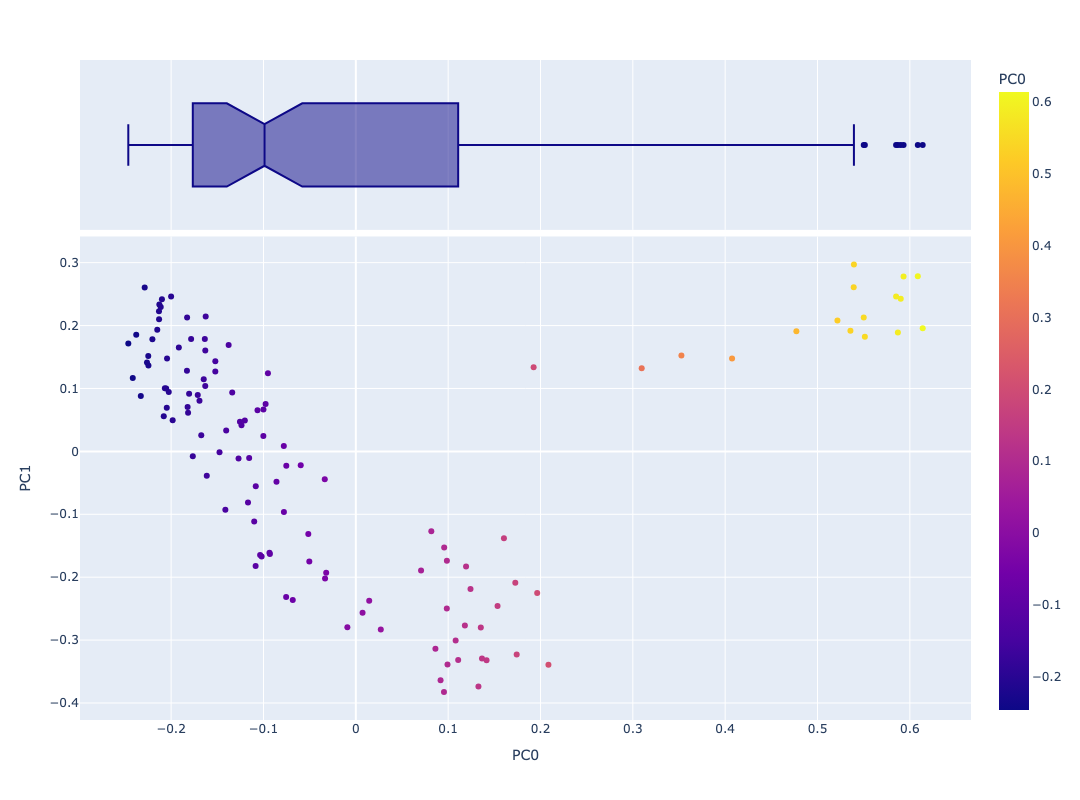

In [41]:
# after amending the DCM to include LIB values, change label back to default
vis_pcs(DCM, 0, 1, label="PC0", hover_name="PC0")

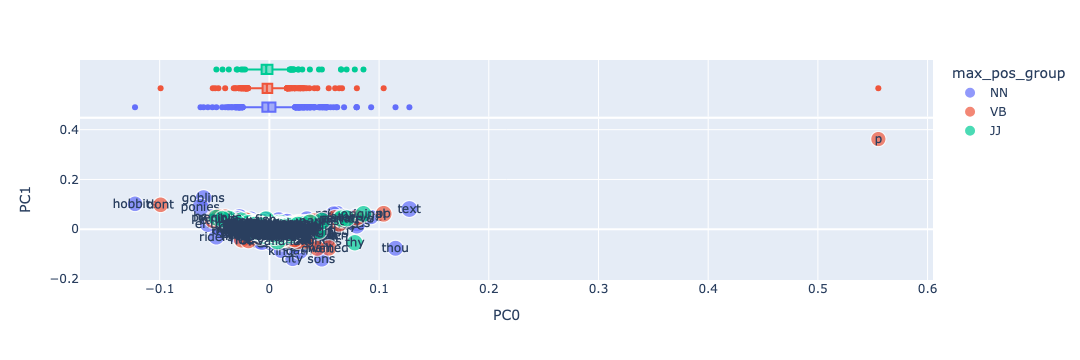

In [42]:
vis_loadings(0,1)

### Next two components

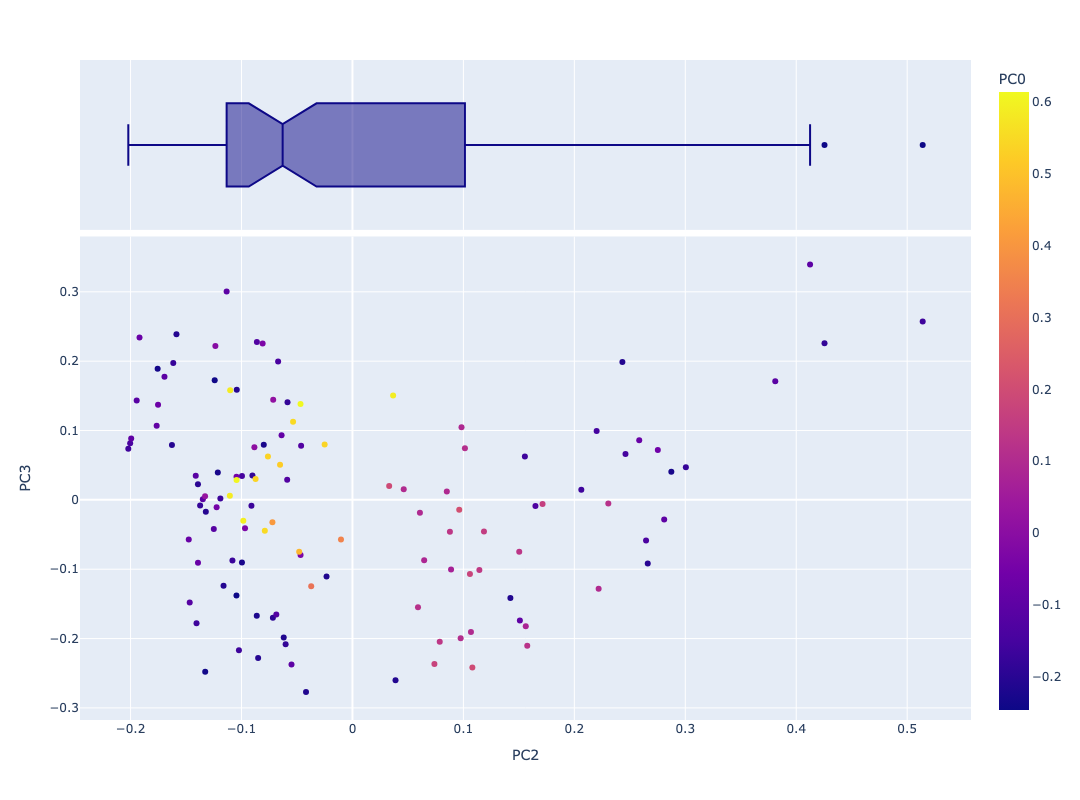

In [43]:
vis_pcs(DCM, 2, 3, label="PC0", hover_name="PC0")

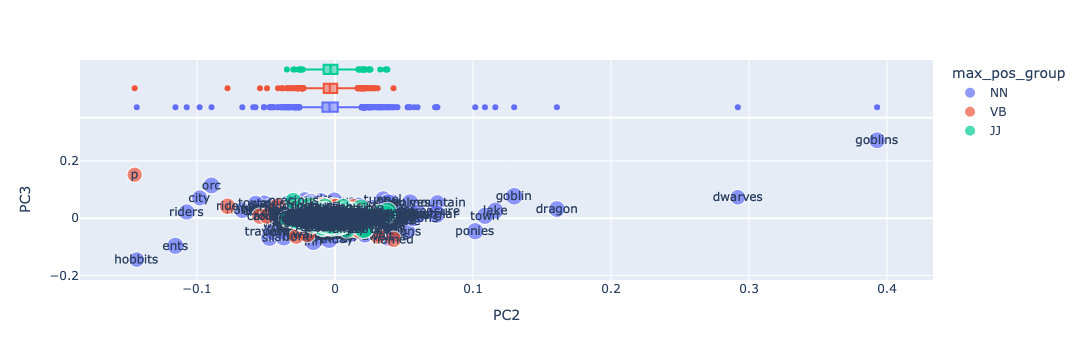

In [44]:
vis_loadings(2, 3)

## LDA

In [45]:
ngram_range = (1, 2)
n_terms = 5000
n_topics = 40
max_iter = 20
n_top_terms = 9

OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

BAG = CHAP

import warnings
warnings.filterwarnings('ignore')

In [46]:
CORPUS

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
1       0        0        0        0              When     when   
                                   1                Mr       mr   
                          1        0             Bilbo    bilbo   
                                   1           Baggins  baggins   
                                   2                of       of   
...                                                ...      ...   
7       47       41       3        11               in       in   
                                   12              the      the   
                                   13            dooms    dooms   
                                   14               of       of   
                                   15           Mandos   mandos   

                                                   pos_tuple  pos pos_group  
book_id chap_num para_num sent_num token_num                                 
1       0        0        0        0             (When, WRB)  WRB        WR  
                                   1               (Mr, NNP)  NNP        NN  
                          1        0            (Bilbo, NNP)  NNP        NN  
                                   1          (Baggins, NNP)  NNP        NN  
                                   2                (of, IN)   IN        IN  
...                                                      ...  ...       ...  
7       47       41       3        11               (in, IN)   IN        IN  
                                   12              (the, DT)   DT        DT  
                                   13           (dooms, NNS)  NNS        NN  
                                   14               (of, IN)   IN        IN  
                                   15          (Mandos, NNP)  NNP        NN  

[948763 rows x 5 columns]

In [92]:
CORPUS.term_str

book_id  chap_num  para_num  sent_num  token_num
1        0         0         0         0               when
                                       1                 mr
                             1         0              bilbo
                                       1            baggins
                                       2                 of
                                                     ...   
7        47        41        3         11                in
                                       12               the
                                       13             dooms
                                       14                of
                                       15            mandos
Name: term_str, Length: 948763, dtype: object

In [47]:
DOCS = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [48]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [49]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [50]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [51]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [52]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

lda_model = lda_engine.fit_transform(count_model)

THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [53]:
THETA

T00       T01       T02       T03       T04       T05  \
book_id chap_num                                                               
1       0         0.000019  0.000019  0.000019  0.000019  0.000019  0.000019   
        1         0.000018  0.000018  0.000018  0.000018  0.000018  0.000018   
        2         0.000017  0.000017  0.000017  0.000017  0.000017  0.000017   
        3         0.000031  0.000031  0.000031  0.000031  0.000031  0.000031   
        4         0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
...                    ...       ...       ...       ...       ...       ...   
7       39        0.003978  0.000034  0.000034  0.000034  0.000034  0.022313   
        41        0.000013  0.000013  0.000013  0.000013  0.000013  0.014786   
        43        0.000035  0.000035  0.000035  0.000035  0.000035  0.000035   
        45        0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
        47        0.000037  0.000037  0.000037  0.000037  0.000037  0.000037   

                       T06       T07       T08       T09  ...       T30  \
book_id chap_num                                          ...             
1       0         0.000019  0.000019  0.000019  0.000019  ...  0.000019   
        1         0.000018  0.000018  0.000018  0.000018  ...  0.000018   
        2         0.000017  0.000017  0.000017  0.000017  ...  0.000017   
        3         0.000031  0.000031  0.000031  0.000031  ...  0.000031   
        4         0.000040  0.000040  0.000040  0.000040  ...  0.000040   
...                    ...       ...       ...       ...  ...       ...   
7       39        0.009205  0.000034  0.000034  0.019249  ...  0.000034   
        41        0.000013  0.000013  0.000013  0.000013  ...  0.000013   
        43        0.000035  0.000035  0.000035  0.000035  ...  0.000035   
        45        0.000040  0.000040  0.000040  0.000040  ...  0.000040   
        47        0.000037  0.000037  0.000037  0.000037  ...  0.000037   

                       T31       T32       T33       T34       T35       T36  \
book_id chap_num                                                               
1       0         0.000019  0.000019  0.000019  0.000019  0.000019  0.000019   
        1         0.000018  0.000018  0.000018  0.000018  0.000018  0.022496   
        2         0.000017  0.000017  0.000017  0.000017  0.000017  0.000017   
        3         0.000031  0.000031  0.000031  0.000031  0.000031  0.000031   
        4         0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
...                    ...       ...       ...       ...       ...       ...   
7       39        0.000034  0.000034  0.000034  0.000034  0.152657  0.000034   
        41        0.000013  0.000013  0.000013  0.000013  0.000013  0.000013   
        43        0.000035  0.000035  0.000035  0.000035  0.000035  0.000035   
        45        0.000040  0.000040  0.000040  0.000040  0.000040  0.000040   
        47        0.000037  0.000037  0.000037  0.000037  0.000037  0.000037   

                       T37       T38       T39  
book_id chap_num                                
1       0         0.000019  0.175106  0.000019  
        1         0.000018  0.346506  0.011583  
        2         0.000017  0.000017  0.000017  
        3         0.000031  0.025562  0.000031  
        4         0.000040  0.000040  0.000040  
...                    ...       ...       ...  
7       39        0.000034  0.000034  0.003257  
        41        0.000013  0.000013  0.000013  
        43        0.000035  0.000035  0.000035  
        45        0.000040  0.000040  0.000040  
        47        0.000037  0.000037  0.156958  

[122 rows x 40 columns]

## PHI

In [54]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [55]:
PHI

term_str  abiding      abode  abodes   absence    absent     abyss  accident  \
topic_id                                                                       
T00         0.025   3.154112   0.025  0.025000  0.025000  0.025000  0.025000   
T01         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T02         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T03         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T04         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T05         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T06         0.025   1.132171   0.025  0.025000  0.025000  0.025000  0.025000   
T07         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T08         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T09         0.025   0.025000   0.025  0.025000  0.025000  1.025000  0.025000   
T10         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T11         0.025   0.025000   0.025  0.025000  0.025000  0.025000  8.796642   
T12         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T13         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T14         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T15         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T16         0.025   0.025000   0.025  0.025000  0.025000  7.532555  0.025000   
T17         0.025   2.236022   0.025  0.025000  0.025000  0.025000  0.025000   
T18         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T19         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T20         0.025   1.025000   1.025  0.025000  0.025000  0.025000  0.025000   
T21         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T22         0.025   0.025000   0.025  1.276254  0.025000  4.159216  0.025000   
T23         0.025   5.171292   0.025  8.195413  1.060724  0.025000  0.025000   
T24         5.025  22.259672   0.025  0.025000  0.025000  1.436162  0.025000   
T25         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T26         0.025  23.198406   4.025  3.107206  1.078423  0.025000  0.025000   
T27         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T28         0.025   0.025000   0.025  0.025000  1.573260  0.025000  0.025000   
T29         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T30         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T31         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T32         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T33         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T34         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T35         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T36         0.025   0.025000   0.025  1.093926  0.025000  0.025000  6.253358   
T37         0.025   0.025000   0.025  0.025000  0.025000  0.025000  0.025000   
T38         0.025   2.837906   0.025  4.452201  0.025000  3.972067  0.025000   
T39         0.025   2.210419   0.025  0.025000  1.387592  0.025000  0.025000   

term_str    accord    account  accounts  ...     youre     youth     youve  \
topic_id                                 ...                                 
T00       0.025000   0.025000  0.025000  ...  0.025000  3.298018  0.025000   
T01       0.025000   0.025000  0.025000  ...  0.025000  0.025000  0.025000   
T02       0.025000   0.025000  0.025000  ...  0.025000  0.025000  0.025000   
T03       0.025000   0.025000  0.025000  ...  0.025000  0.025000  0.025000   
T04       0.025000   0.025000  0.025000  ...  0.025000  0.025000  0.025000   
T05       0.025000   0.025000  0.025000  ...  0.025000  2.090786  0.025000   
T06       0.025

## TOPICS

In [56]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [57]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [95]:
TOPICS.sort_values('doc_weight_sum', ascending=False)

top_terms  doc_weight_sum  \
topic_id                                                                      
T14           way night time trees water eyes day hand land       20.700525   
T24       elves son people time earth land heart power w...       18.845572   
T11       time hobbits way things night end hobbit round...       10.670023   
T22        way eyes head road hobbits light master hand end       10.341612   
T38       hand eyes things thing time power face moment ...        7.621360   
T29       dwarves goblins hobbit gold dragon time door w...        6.388932   
T13        trees hobbits time water land way hill ents feet        6.352717   
T39       elves sea time men days father world story waters        5.411031   
T28       world light tale gold earth silver trees thing...        4.439752   
T26       tale folk elves place story king heart passage...        4.356717   
T05            man men son eyes lord king horses voice hall        3.373127   
T35        men road host king battle day war strength hills        3.075699   
T09        days time men heart people day words king things        2.453830   
T27        men wall walls enemy door man gates doom chamber        2.372897   
T00       things draft music world heart text glory tong...        1.910208   
T31       town elves dwarves barrels river water map lak...        1.670218   
T10       hand eyes tunnel sword way light darkness air ...        1.605178   
T36       folk hobbits landlord door night man letter ne...        1.494389   
T17       land wind snow way hobbits night light mountai...        1.477872   
T16       city men walls fall plain battle river king voice        1.412462   
T06       people son tongue lands land folk elves time sons        1.264804   
T33       earth east heaven light time shadows lights mi...        1.139361   
T20       tale elves outlines host story time outline wo...        1.005509   
T12       http http http abiding rekindling rejoice reje...        0.906383   
T23        men tale folk story heart place gold words death        0.776053   
T01       world things trees time sea house stars text h...        0.668481   
T04       sea shores hair shore swans island waves ships...        0.154250   
T18       elves dwarves staff sons daughter sun clouds h...        0.034437   
T37       abiding refreshment rejection regret regions r...        0.006383   
T03       abiding refreshment rejection regret regions r...        0.006383   
T02       abiding refreshment rejection regret regions r...        0.006383   
T34       abiding refreshment rejection regret regions r...        0.006383   
T15       abiding refreshment rejection regret regions r...        0.006383   
T32       abiding refreshment rejection regret regions r...        0.006383   
T30       abiding refreshment rejection regret regions r...        0.006383   
T08       abiding refreshment rejection regret regions r...        0.006383   
T25       abiding refreshment rejection regret regions r...        0.006383   
T21       abiding refreshment rejection regret regions r...        0.006383   
T19       abiding refreshment rejection regret regions r...        0.006383   
T07       abiding refreshment rejection regret regions r...        0.006383   

          term_freq  
topic_id             
T14        0.159647  
T24        0.120855  
T11        0.069499  
T22        0.080920  
T38        0.058657  
T29        0.035623  
T13        0.057918  
T39        0.075411  
T28        0.042093  
T26        0.083033  
T05        0.028756  
T35        0.018563  
T09        0.013586  
T27        0.020393  
T00        0.009777  
T31        0.008604  
T10        0.011096  
T36        0.008148  
T17        0.012654  
T16        0.016909  
T06        0.006875  
T33        0.003763  
T20        0.008605  
T12        0.000909  
T23        0.028084  
T01        0.007177  
T04        0.001282  
T18        0.000984  
T37        0.000848  
T03        0.000848  
T02        0.000848  
T34  

## PCA Visualizations

In [59]:
PHI_DCM, LOADINGS = create_pca(PHI)

In [60]:
vis_pcs(PHI_DCM, 0, 1, label="PC0", hover_name="PC0")

In [61]:
vis_loadings(0, 1)

## Sentiment Analysis

In [62]:
salex_csv = 'lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [63]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

### VOCAB_SENT:

In [64]:
V = pd.concat([VOCAB_final.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V.head()

n  n_chars         p          i max_pos max_pos_group  stop  \
term_str                                                                    
abandon      18        7  0.000019  15.685763      VB            VB     0   
abandoned    34        9  0.000036  14.768225     VBN            VB     0   
abandonment   2       11  0.000002  18.855688      NN            NN     0   
abominable    8       10  0.000008  16.855688      JJ            JJ     0   
absence      19        7  0.000020  15.607761      NN            NN     0   

            porter_stem      dfidf  anger  anticipation  disgust  fear  joy  \
term_str                                                                      
abandon         abandon  41.993869      0             0        0     1    0   
abandoned       abandon  48.335666      1             0        0     1    0   
abandonment     abandon  11.861475      1             0        0     1    0   
abominable       abomin  31.445899      0             0        1     1    0   
absence          absenc  33.847311      0             0        0     1    0   

             negative  positive  sadness  surprise  trust  sentiment  
term_str                                                              
abandon             1         0        1         0      0         -1  
abandoned           1         0        1         0      0         -1  
abandonment         1         0        1         1      0         -1  
abominable          1         0        0         0      0         -1  
absence             1         0        1         0      0         -1

### BOW_SENT:

In [65]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [66]:
B

n     tfidf max_pos  anger  anticipation  \
book_id chap_num term_str                                                
1       0        abominable   1  0.008716      JJ    0.0           0.0   
                 abundant     1  0.013150      JJ    0.0           0.0   
                 accident     1  0.008339      NN    0.0           0.0   
                 accusing     1  0.011853     VBG    1.0           0.0   
                 admirable    1  0.011853      JJ    0.0           0.0   
...                          ..       ...     ...    ...           ...   
7       47       white       11  0.004288      JJ    0.0           1.0   
                 word         1  0.000976      NN    0.0           0.0   
                 worn         3  0.012107     VBN    0.0           0.0   
                 wrath        2  0.005027      NN    1.0           0.0   
                 young        1  0.002232      JJ    0.0           1.0   

                             disgust  fear  joy  sadness  surprise  trust  \
book_id chap_num term_str                                                   
1       0        abominable      1.0   1.0  0.0      0.0       0.0    0.0   
                 abundant        0.0   0.0  1.0      0.0       0.0    0.0   
                 accident        0.0   1.0  0.0      1.0       1.0    0.0   
                 accusing        0.0   1.0  0.0      0.0       0.0    0.0   
                 admirable       0.0   0.0  1.0      0.0       0.0    1.0   
...                              ...   ...  ...      ...       ...    ...   
7       47       white           0.0   0.0  1.0      0.0       0.0    1.0   
                 word            0.0   0.0  0.0      0.0       0.0    1.0   
                 worn            0.0   0.0  0.0      1.0       0.0    0.0   
                 wrath           0.0   1.0  0.0      0.0       0.0    0.0   
                 young           0.0   0.0  1.0      0.0       1.0    0.0   

                             sentiment  
book_id chap_num term_str               
1       0        abominable       -1.0  
                 abundant          1.0  
                 accident         -1.0  
                 accusing         -1.0  
                 admirable         1.0  
...                                ...  
7       47       white             1.0  
                 word              1.0  
                 worn             -1.0  
                 wrath            -1.0  
                 young             1.0  

[22086 rows x 12 columns]

### DOC_SENT:

In [67]:
BAG = OHCO[:2] # CHAPS
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()

In [68]:
EMO_CHAPS

anger  anticipation   disgust      fear       joy  \
book_id chap_num                                                         
1       0         0.224000      0.348000  0.160000  0.276000  0.412000   
        1         0.293893      0.251908  0.213740  0.435115  0.232824   
        2         0.202073      0.331606  0.160622  0.284974  0.331606   
        3         0.258993      0.208633  0.122302  0.374101  0.316547   
        4         0.200000      0.318519  0.133333  0.288889  0.348148   
...                    ...           ...       ...       ...       ...   
7       39        0.368421      0.225564  0.165414  0.473684  0.187970   
        41        0.320423      0.211268  0.179577  0.447183  0.207746   
        43        0.346939      0.238095  0.197279  0.401361  0.217687   
        45        0.293651      0.277778  0.190476  0.452381  0.261905   
        47        0.294964      0.273381  0.158273  0.366906  0.287770   

                   sadness  surprise     trust  sentiment  
book_id chap_num                                           
1       0         0.264000  0.240000  0.356000   0.100000  
        1         0.370229  0.145038  0.255725  -0.236641  
        2         0.279793  0.202073  0.326425   0.031088  
        3         0.323741  0.158273  0.302158  -0.122302  
        4         0.274074  0.177778  0.370370  -0.007407  
...                    ...       ...       ...        ...  
7       39        0.300752  0.135338  0.278195  -0.315789  
        41        0.404930  0.133803  0.257042  -0.306338  
        43        0.380952  0.108844  0.238095  -0.292517  
        45        0.365079  0.103175  0.301587  -0.103175  
        47        0.381295  0.086331  0.280576  -0.151079  

[122 rows x 9 columns]

In [69]:
FELLOWSHIP_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(1))
TOWERS_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(2))
KING_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(3))
HOBBIT_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(4))

In [70]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [71]:
px.line(FELLOWSHIP_chaps_thin, x='chap_num', y='value', color='emo')

In [72]:
px.line(TOWERS_chaps_thin, x='chap_num', y='value', color='emo')

In [73]:
px.line(KING_chaps_thin, x='chap_num', y='value', color='emo')

In [74]:
px.line(HOBBIT_chaps_thin, x='chap_num', y='value', color='emo')

## Word Embedding

In [75]:
VOCAB = VOCAB_final
TOKENS = CORPUS

# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [76]:
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
vocab = Dictionary(docs)

In [77]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [78]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [79]:
WV

0         1         2         3         4         5    \
term_str                                                               
          0.208360  0.149616  0.247335 -0.780992  0.251900  0.350615   
1        -0.024575  0.014904 -0.041286  0.029513 -0.052786  0.004365   
10       -0.037453  0.041910 -0.052188  0.065693 -0.046823 -0.041987   
2         0.029308 -0.030862 -0.081113  0.040540 -0.013546 -0.006129   
3        -0.006696 -0.035097 -0.063493  0.119277 -0.034130 -0.016974   
...            ...       ...       ...       ...       ...       ...   
youve    -0.065345  0.022994  0.253103 -0.094201  0.135320 -0.005401   
ælfwine  -0.038775 -0.034010 -0.113031  0.121403  0.070605  0.055934   
éomer     0.158996  0.056840  0.314060 -0.104064  0.213896  0.009169   
éowyn     0.117833 -0.104500  0.118954 -0.010500  0.168669 -0.049384   
úrin     -0.049029 -0.071287  0.077378  0.242133  0.040488 -0.064282   

               6         7         8         9    ...       190       191  \
term_str                                          ...                       
         -0.268664 -0.022354  0.730013  0.266885  ...  0.318779  0.260276   
1        -0.067545  0.118528 -0.046165  0.053148  ...  0.121890  0.023148   
10        0.020070  0.117195 -0.085536  0.084083  ...  0.079034 -0.000221   
2        -0.051052  0.077442 -0.013307  0.100099  ...  0.084260  0.008125   
3        -0.043355  0.145558 -0.047126  0.041805  ...  0.115144 -0.019680   
...            ...       ...       ...       ...  ...       ...       ...   
youve     0.232058 -0.173584 -0.085624 -0.078945  ...  0.314816  0.201305   
ælfwine   0.103406  0.069156  0.118532  0.000362  ...  0.061222 -0.010336   
éomer    -0.077067 -0.174728  0.436081  0.273541  ...  0.001327  0.028348   
éowyn    -0.002204 -0.070181  0.355969  0.083886  ...  0.073770  0.000854   
úrin     -0.054389 -0.020548 -0.008417  0.116906  ...  0.091861 -0.100767   

               192       193       194       195       196       197  \
term_str                                                               
         -0.008443 -0.098461  0.345383 -0.417148 -0.162864 -0.634463   
1        -0.135754 -0.201144  0.075307 -0.056433  0.118122 -0.238852   
10       -0.117694 -0.179892  0.104516 -0.040113  0.076541 -0.206547   
2        -0.108340 -0.186498  0.018502 -0.010424  0.136731 -0.204905   
3        -0.171362 -0.197997  0.066330  0.001447  0.091912 -0.219630   
...            ...       ...       ...       ...       ...       ...   
youve    -0.185416 -0.301367 -0.128806 -0.080196  0.223875 -0.033141   
ælfwine  -0.228500 -0.313234 -0.020557 -0.019870  0.207961 -0.244802   
éomer    -0.376373 -0.438540  0.243463  0.010576 -0.298412 -0.264196   
éowyn    -0.285557 -0.493859  0.040785  0.062170 -0.010431 -0.377380   
úrin     -0.161129 -0.276681 -0.083837 -0.025059  0.165174 -0.169386   

               198       199  
term_str                      
         -0.223113  0.084117  
1        -0.215311 -0.167268  
10       -0.116180 -0.153241  
2        -0.169776 -0.095767  
3        -0.243530 -0.122322  
...            ...       ...  
youve    -0.190723 -0.178218  
ælfwine  -0.053819 -0.000854  
éomer     0.010335  0.252657  
éowyn    -0.098337  0.035524  
úrin     -0.192622 -0.031552  

[1711 rows x 200 columns]

### TSNE Plot

In [80]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [81]:
X = TSNE.join(VOCAB, how='left')

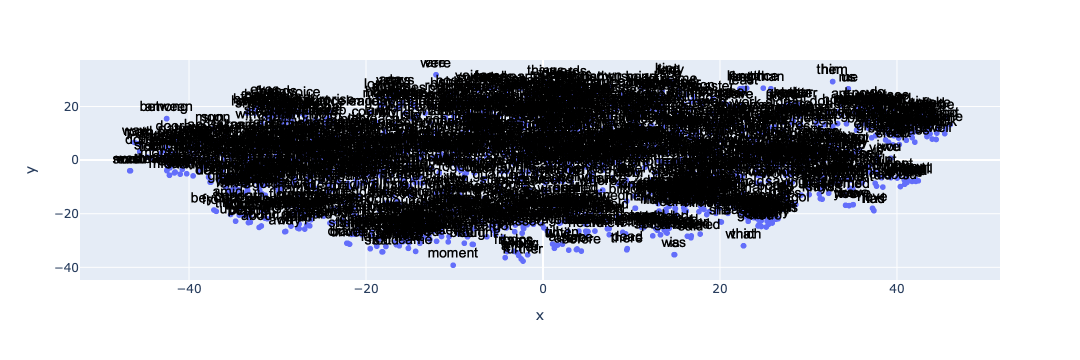

In [82]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           # color='pos_max', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# RIFFS

### Riff 1

In [83]:
def top_books_for_term(term_str):
    X = BOW.join(LIB).query(f"term_str == '{term_str}'").groupby(['book_author','book_title'])\
        .agg({'tfidf':'mean', 'n':'sum'})
    return px.scatter(X.reset_index(), 'n','tfidf', color='book_author',
                      hover_name='book_title', 
                      height=500, width=600, title=f"{term_str}")

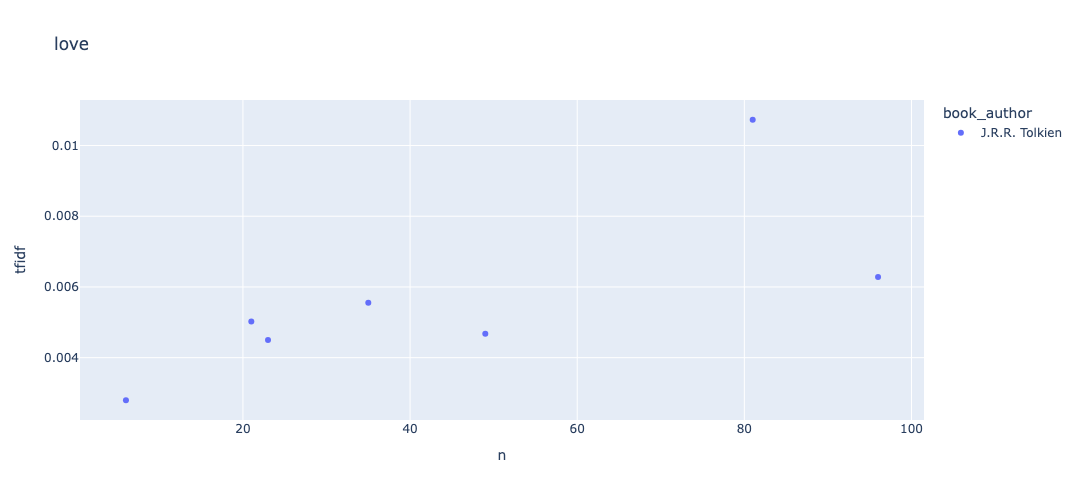

In [84]:
top_books_for_term("love")

### Riff 2

In [85]:
TFIDF.groupby('book_id').mean()

term_str  knowledge   shouted   setting      busy     burst      sank  \
book_id                                                                 
1          0.002096  0.003715  0.001698  0.002836  0.002166  0.001766   
2          0.000922  0.003303  0.001183  0.002044  0.000919  0.002597   
3          0.001572  0.002219  0.001562  0.004215  0.002194  0.002440   
4          0.001698  0.006318  0.002090  0.004068  0.002535  0.001828   
5          0.003561  0.000549  0.001284  0.000770  0.001013  0.001141   
6          0.003244  0.000490  0.001208  0.000099  0.000682  0.000726   
7          0.004429  0.000151  0.000527  0.000217  0.000845  0.000333   

term_str     story  listened    figure    mortal  ...  overjoyed    meddle  \
book_id                                           ...                        
1         0.004444  0.002369  0.003586  0.001684  ...   0.000583  0.000796   
2         0.002907  0.003365  0.002976  0.001373  ...   0.000000  0.002511   
3         0.001436  0.001368  0.001962  0.001622  ...   0.000000  0.000000   
4         0.003162  0.001851  0.000756  0.000597  ...   0.000568  0.000000   
5         0.014013  0.000627  0.000331  0.001247  ...   0.000336  0.000000   
6         0.019781  0.000163  0.001098  0.002527  ...   0.000291  0.000000   
7         0.000000  0.000884  0.000118  0.005149  ...   0.000000  0.000000   

term_str      ruth    wretch  happenings  memorial     pains    scents  \
book_id                                                                  
1         0.000000  0.000390    0.000350  0.000000  0.000000  0.000000   
2         0.000000  0.002850    0.000000  0.000000  0.000000  0.000569   
3         0.000000  0.000000    0.000000  0.000592  0.003277  0.000000   
4         0.000000  0.000834    0.001370  0.000000  0.000000  0.000000   
5         0.001446  0.000000    0.002145  0.000000  0.000336  0.001596   
6         0.002555  0.000000    0.000581  0.000466  0.000346  0.000000   
7         0.000000  0.000000    0.000000  0.002368  0.000000  0.000614   

term_str   gullies   spurred  
book_id                       
1         0.000753  0.001002  
2         0.001133  0.000560  
3         0.000000  0.001189  
4         0.001244  0.000000  
5         0.000000  0.000000  
6         0.000000  0.000000  
7         0.000000  0.000225  

[7 rows x 5000 columns]

In [86]:
# corr_type = 'pearson'
corr_type = 'kendall'
# corr_type = 'spearman'

CORR_MATRIX = TFIDF.groupby('book_id').mean().T.corr(corr_type)

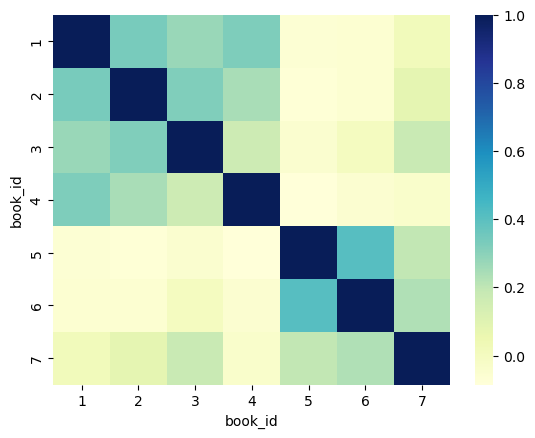

In [87]:
sns.heatmap(CORR_MATRIX, cmap=colors);

### Riff 3